#IMAGE CLASSIFICATION FOR SMOKE DETECTION


In [ ]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

**Unzipping data from the drive and loading them.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/USTC_SmokeRS.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dust/dust_149.tif       
  inflating: Dust/dust_15.tif        
  inflating: Dust/dust_150.tif       
  inflating: Dust/dust_151.tif       
  inflating: Dust/dust_152.tif       
  inflating: Dust/dust_153.tif       
  inflating: Dust/dust_154.tif       
  inflating: Dust/dust_155.tif       
  inflating: Dust/dust_156.tif       
  inflating: Dust/dust_157.tif       
  inflating: Dust/dust_158.tif       
  inflating: Dust/dust_159.tif       
  inflating: Dust/dust_16.tif        
  inflating: Dust/dust_160.tif       
  inflating: Dust/dust_161.tif       
  inflating: Dust/dust_162.tif       
  inflating: Dust/dust_163.tif       
  inflating: Dust/dust_164.tif       
  inflating: Dust/dust_165.tif       
  inflating: Dust/dust_166.tif       
  inflating: Dust/dust_167.tif       
  inflating: Dust/dust_168.tif       
  inflating: Dust/dust_169.tif       
  inflating: Dust/dust_17.tif        
  inflating: Dust/dust_170.tif       

#**DATA PRE PROCESSING**

we have all images to our working folder. lets visualize the data using plots.


In [ ]:
DATASET = "/content/datsetSmoker" #path to the folder containg all the images

LABELS = os.listdir(DATASET) #class names
print(LABELS)



['.ipynb_checkpoints', 'dust', 'cloud', 'land', 'seaside', 'smoke', 'haze']


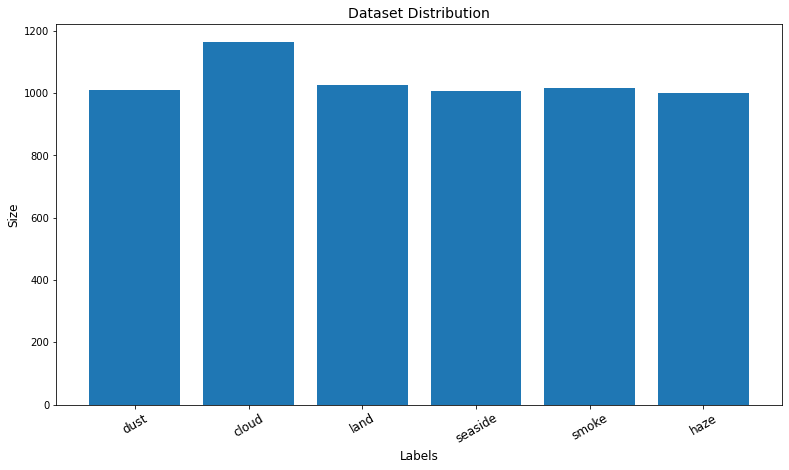

In [ ]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
  if(l!='.ipynb_checkpoints'):
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(13, 7))
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=30)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Size', fontsize=12)
plt.title('Dataset Distribution', fontsize=14);

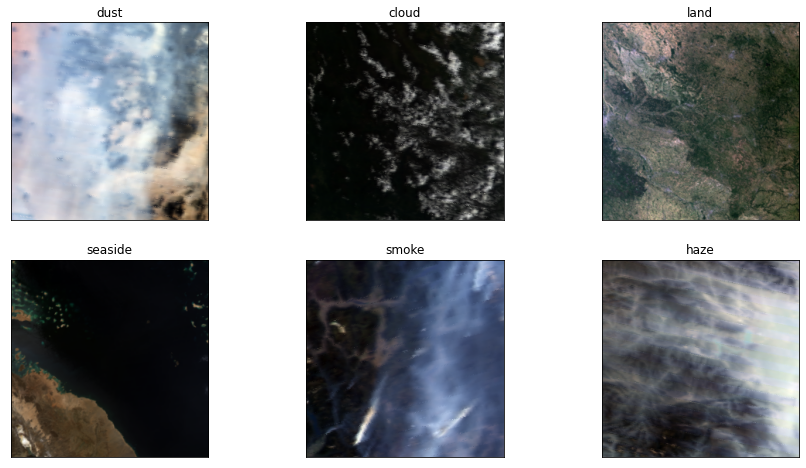

In [ ]:
 #plotting an image from all the labels using paths of the image
import tifffile as tiff
LABELS.remove('.ipynb_checkpoints')
paths = [os.path.join(DATASET, l, l+'_500.tif') for l in LABELS]
plt.figure(figsize=(15, 8))
for i in range(6):
        plt.subplot(2, 3, i+1, xticks=[], yticks=[])
        img=tiff.imread(paths[i])
        plt.imshow(img)
        plt.title(paths[i].split('/')[-2])



In [ ]:
#splitting the data for traing and testing using 'stratified shufflesplit' and 'image data generator'.
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/content/training'
TEST_DIR = '/content/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [ ]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
       data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('/content/datsetSmoker', '/content/training', i) for i in train_paths]
    new_test_paths = [re.sub('/content/datsetSmoker', '/content/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  5%|▌         | 272/4980 [00:00<00:01, 2711.63it/s]

moving training files..


 13%|█▎        | 166/1245 [00:00<00:00, 1593.15it/s]

moving testing files..


100%|██████████| 1245/1245 [00:01<00:00, 1142.28it/s]


In [ ]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)


# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 4980 images belonging to 6 classes.
Found 1245 images belonging to 6 classes.


In [ ]:
#class indicies to identify each class
print(train_generator.class_indices)

{'cloud': 0, 'dust': 1, 'haze': 2, 'land': 3, 'seaside': 4, 'smoke': 5}


In [ ]:
np.save('class_indices', train_generator.class_indices)

#**MODEL BUILDING**



In [ ]:
#importing all required libraries
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications import ResNet50V2
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [ ]:
#setting up GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [ ]:
# function for setting up of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    

  conv_base = ResNet50V2(include_top=False,
                      weights='imagenet', 
                      input_shape=input_shape)

  top_model = conv_base.output
  top_model = Flatten()(top_model)
  top_model = Dense(2048, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
    
  output_layer = Dense(n_classes, activation='softmax')(top_model)
    
  model = Model(inputs=conv_base.input, outputs=output_layer)
        
  if type(fine_tune) == int:
      for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
  else:
       for layer in conv_base.layers:
            layer.trainable = False

  model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
  return model
# function for plotting model history
def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();
# function for results and metrics
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat
#function for plotting predictions
def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

**1.RESNET50V2**

In [ ]:
#creating the model
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50V2_model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_____________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')


In [ ]:
# First Pretraining the dense layer
resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
77/77 [==============================] - 50s 216ms/step - loss: 17.5561 - categorical_accuracy: 0.4131 - val_loss: 1.4506 - val_categorical_accuracy: 0.5444

Epoch 00001: val_categorical_accuracy improved from -inf to 0.54441, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
77/77 [==============================] - 15s 190ms/step - loss: 1.4708 - categorical_accuracy: 0.5275 - val_loss: 1.1775 - val_categorical_accuracy: 0.6283

Epoch 00002: val_categorical_accuracy improved from 0.54441 to 0.62829, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
77/77 [==============================] - 15s 188ms/step - loss: 1.2466 - categorical_accuracy: 0.5699 - val_loss: 1.2669 - val_categorical_accuracy: 0.6143

Epoch 00003: val_categorical_accuracy did not improve from 0.62829
Epoch 4/50
77/77 [==============================] - 15s 194ms/step - loss: 1.3397 - categorical_accuracy: 0.5930 - val_loss: 1.1446 - val_categorical_accuracy: 0.6439

Epoch 00004: val_

In [ ]:
# re-train whole network end2end 
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
77/77 [==============================] - 28s 267ms/step - loss: 1.7712 - categorical_accuracy: 0.4575 - val_loss: 1.1671 - val_categorical_accuracy: 0.6217

Epoch 00001: val_categorical_accuracy did not improve from 0.71217
Epoch 2/100
77/77 [==============================] - 18s 236ms/step - loss: 1.0622 - categorical_accuracy: 0.6239 - val_loss: 1.0685 - val_categorical_accuracy: 0.6513

Epoch 00002: val_categorical_accuracy did not improve from 0.71217
Epoch 3/100
77/77 [==============================] - 18s 235ms/step - loss: 0.9149 - categorical_accuracy: 0.6820 - val_loss: 0.8423 - val_categorical_accuracy: 0.7229

Epoch 00003: val_categorical_accuracy improved from 0.71217 to 0.72286, saving model to ../working/model.weights.best.hdf5
Epoch 4/100
77/77 [==============================] - 18s 234ms/step - loss: 0.7949 - categorical_accuracy: 0.7316 - val_loss: 0.6622 - val_categorical_accuracy: 0.7870

Epoch 00004: val_categorical_accuracy improved from 0.72286 to 0.78

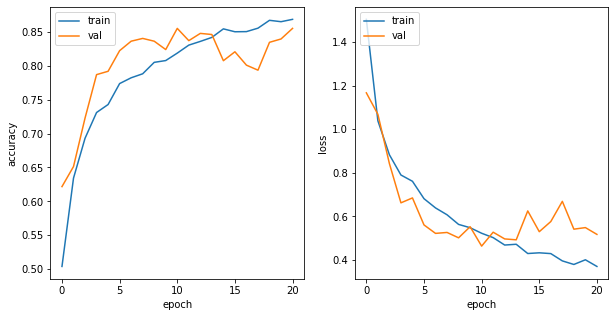

In [ ]:
#plotting the model history
plot_history(resnet50V2_history)

In [ ]:
#finding scores of the metrics defined
resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf
resnet50V2_model.save('/content/drive/MyDrive/resnet50v2_smoke.h5')

Found 1245 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.8433734939759037
Global F2 Score: 0.8433734939759037


**2.VGG 16**

In [ ]:
from keras.applications import VGG16

vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg16_model.summary()
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)




Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
77/77 [==============================] - 19s 204ms/step - loss: 17.6766 - categorical_accuracy: 0.4180 - val_loss: 1.3662 - val_categorical_accuracy: 0.5715

Epoch 00001: val_categorical_accuracy improved from -inf to 0.57155, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
77/77 [==============================] - 14s 187ms/step - loss: 1.5121 - categorical_accuracy: 0.5422 - val_loss: 1.2418 - val_categorical_accuracy: 0.6431

Epoch 00002: val_categorical_accuracy improved from 0.57155 to 0.64309, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
77/77 [==============================] - 14s 183ms/step - loss: 1.3313 - categorical_accuracy: 0.5706 - val_loss: 1.1613 - val_categorical_accuracy: 0.6472

Epoch 00003: val_categorical_accuracy improved from 0.64309 to 0.64720, saving model to ../working/model.weights.best.hdf5
Epoch 4/50
77/77 [==============================] - 14s 182ms/step - loss: 1.2976 - categorical_accuracy: 0.5823 - val_loss: 1.20

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
77/77 [==============================] - 25s 241ms/step - loss: 2.0692 - categorical_accuracy: 0.4449 - val_loss: 1.2675 - val_categorical_accuracy: 0.5461

Epoch 00001: val_categorical_accuracy did not improve from 0.69572
Epoch 2/100
77/77 [==============================] - 17s 226ms/step - loss: 1.2215 - categorical_accuracy: 0.5415 - val_loss: 1.0859 - val_categorical_accuracy: 0.6209

Epoch 00002: val_categorical_accuracy did not improve from 0.69572
Epoch 3/100
77/77 [==============================] - 18s 227ms/step - loss: 1.0294 - categorical_accuracy: 0.6362 - val_loss: 0.8200 - val_categorical_accuracy: 0.7294

Epoch 00003: val_categorical_accuracy improved from 0.69572 to 0.72944, saving model to ../working/model.weights.best.hdf5
Epoch 4/100
77/77 [==============================] - 18s 227ms/step - loss: 1.0568 - categorical_accuracy: 0.6697 - val_loss: 0.8183 - val_categorical_accuracy: 0.7212

Epoch 00004: val_categorical_accuracy did not improve from 0.72944


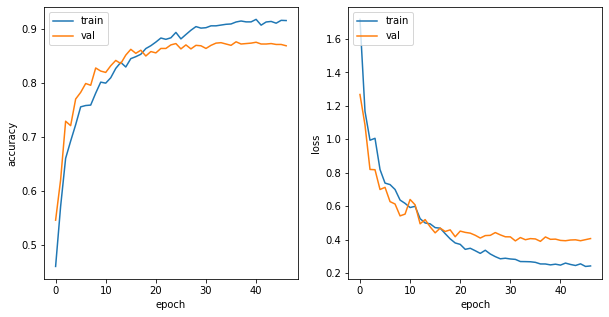

In [ ]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg16_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)
plot_history(vgg16_history)




In [ ]:
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf
vgg16_model.save('/content/drive/MyDrive/vgg16_smoke.h5')

Found 1245 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.8626506024096385
Global F2 Score: 0.8626506024096385


In [ ]:
from keras.models import load_model
import tensorflow as tf

model = load_model("/content/vgg16_smoke.h5")


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

print("model converted")

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7h0bb04a/assets
model converted


**WE CAN SEE THAT VGG16(0.8626506024096385) HAS A BETTER ACCURACY VALUE OF THAN RESNET50V2(0.8433734939759037)**

**So we deploy VGG16 in our model for SMOKE DETECTION**